In [1]:
from fastMONAI.vision_all import *

In [5]:
STUDY_DIR = "/home/yw4196/Snapshot_T1_DeepLearning"
df = pd.read_csv('Snapshot_tidy.csv')
df

,patients,"Sex (1=M, 2=F)",Age (years),SDMT,images
0,9001,2,35,35,/home/yw4196/Snapshot_T1_DeepLearning/9001_T1_nu_acpc.nii.gz
1,9003,2,53,56,/home/yw4196/Snapshot_T1_DeepLearning/9003_T1_nu_acpc.nii.gz
2,9004,2,52,54,/home/yw4196/Snapshot_T1_DeepLearning/9004_T1_nu_acpc.nii.gz
3,9005,1,37,31,/home/yw4196/Snapshot_T1_DeepLearning/9005_T1_nu_acpc.nii.gz
4,9006,2,39,38,/home/yw4196/Snapshot_T1_DeepLearning/9006_T1_nu_acpc.nii.gz
...,...,...,...,...,...
120,9270,1,48,25,/home/yw4196/Snapshot_T1_DeepLearning/9270_T1_nu_acpc.nii.gz
121,9278,2,33,63,/home/yw4196/Snapshot_T1_DeepLearning/9278_T1_nu_acpc.nii.gz
122,9279,2,55,65,/home/yw4196/Snapshot_T1_DeepLearning/9279_T1_nu_acpc.nii.gz
123,9286,1,37,49,/home/yw4196/Snapshot_T1_DeepLearning/9286_T1_nu_acpc.nii.gz


In [6]:
df.SDMT.min(), df.SDMT.max()

(0, 85)

In [7]:
med_dataset = MedDataset(path=STUDY_DIR, max_workers=1)

In [8]:
data_info_df = med_dataset.summary()

In [9]:
data_info_df

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,256,256,256,1.0,1.0,1.0,LIA+,/home/yw4196/Snapshot_T1_DeepLearning/9001_T1_nu_acpc.nii.gz,125


In [10]:
resample, reorder = med_dataset.suggestion()

In [11]:
bs=2
in_shape = [1, 256, 256, 256]

In [12]:
item_tfms = [ZNormalization(), PadOrCrop(in_shape[1:]), RandomAffine(scales=0, degrees=5, isotropic=False)] 

In [13]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), RegressionBlock), 
                      splitter=RandomSplitter(seed=32),
                      get_x=ColReader('images'),
                      get_y=ColReader('SDMT'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [14]:
dls = dblock.dataloaders(df, bs=bs)

In [15]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(100, 25)

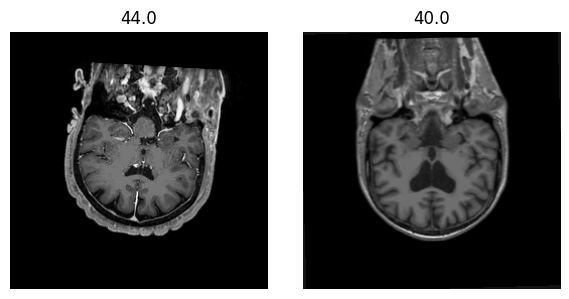

In [24]:
dls.show_batch(anatomical_plane=2)

# Create CNN model

In [16]:
from monai.networks.nets import Regressor
model = Regressor(in_shape=[1, 256, 256, 256], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

loss_func = L1LossFlat()


In [17]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[mae])

learn.summary()


Regressor (Input shape: 2 x 1 x 256 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 16 x 128 x 128  
Conv3d                                    448        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    448        True      
____________________________________________________________________________
                     2 x 32 x 64 x 64 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    27680      True      
InstanceNorm3d        

SuggestedLRs(valley=0.00010964782268274575)

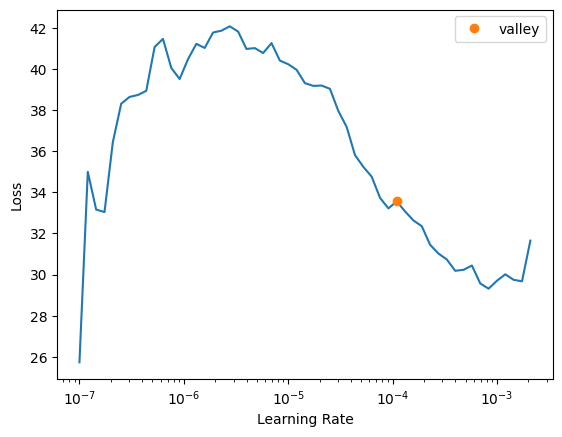

In [27]:
learn.lr_find()

In [22]:


lr = 1e-4

learn.fit_one_cycle(4)



epoch,train_loss,valid_loss,mae,time
0,15.875632,18.945930,18.945930,03:24
1,19.096815,46.862637,46.862637,02:29
2,25.409605,15.141099,15.141099,03:11
3,17.611277,13.658187,13.658187,02:10


In [23]:
learn.save('model-brainSDMT8'); 

# Inference

In [18]:
learn.load('model-brainSDMT'); 

In [19]:
interp = Interpretation.from_learner(learn)

In [38]:
interp.top_losses(13)

(TensorBase([23.2457, 23.2364, 20.1939, 20.1913, 19.4222, 17.4815, 16.8596,
             16.7951, 16.4542, 14.5967, 13.5136, 13.4266,  8.8190]),
 TensorBase([24,  7, 16,  1,  5,  9,  6, 17, 11, 13, 14,  0, 12]))

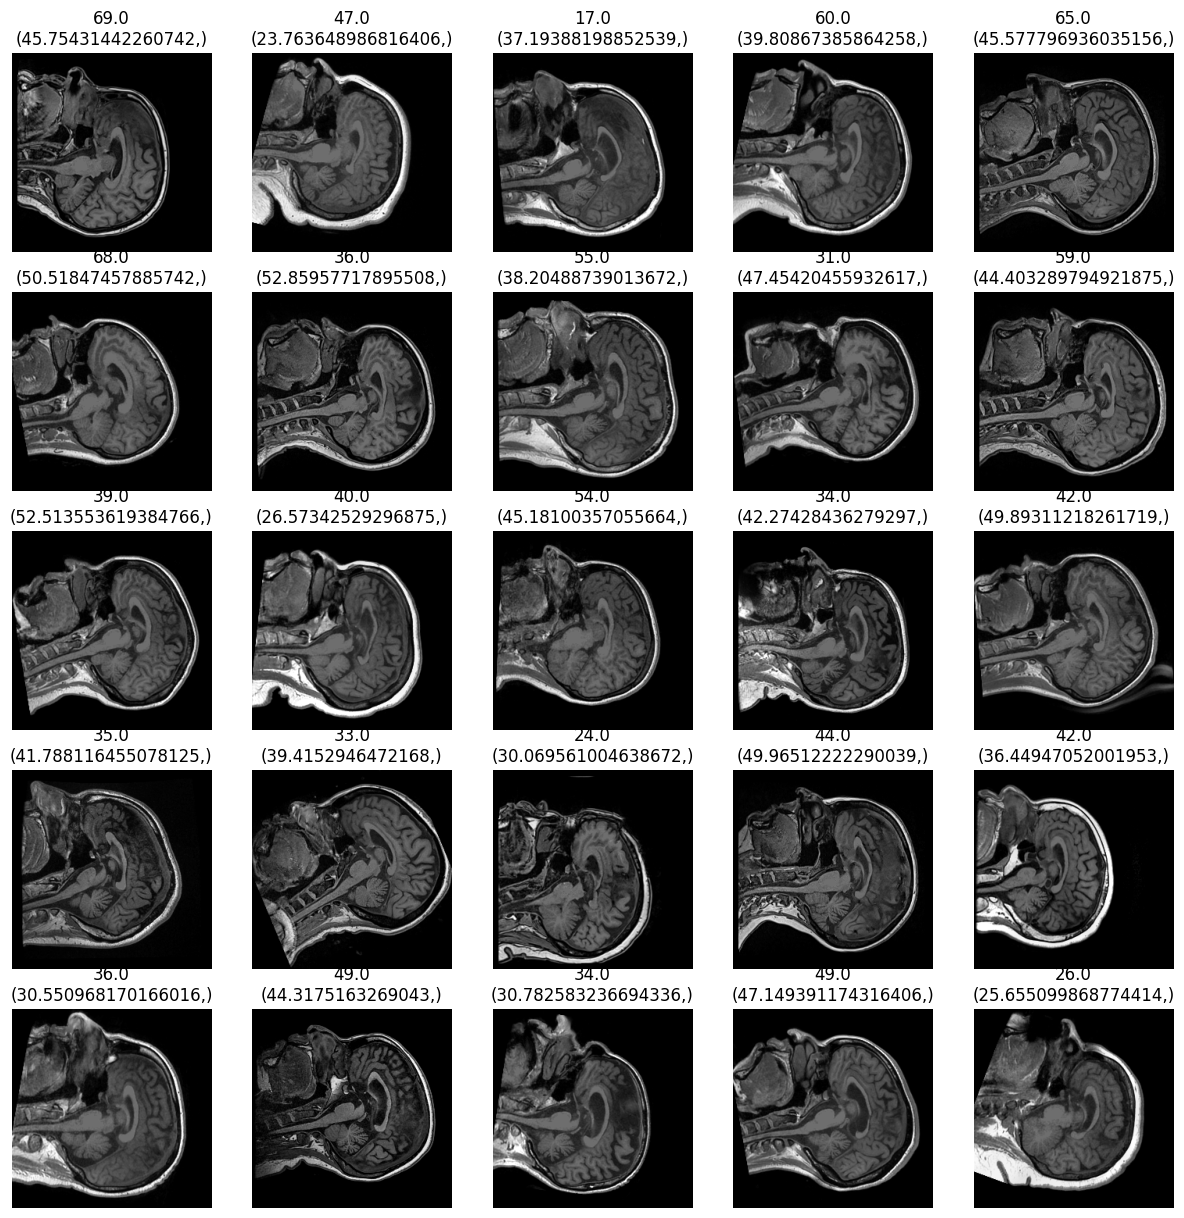

In [21]:
interp.show_results(interp.top_losses(25)[1])